In [4]:
import numpy as np
import matplotlib #everthing works fine, no backend selected yet
matplotlib.use("TkAgg") #backend selected, would still be fine even if Tk wasnt installed.
from pygsp import graphs, filters
from pygsp import plotting as gsp_plt
from nilearn import image, plotting, datasets


/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Defaulting to user installation because normal site-packages is not writeable
  Created wheel for TADtool: filename=tadtool-0.82-py3-none-any.whl size=19036 sha256=4917e00f2eff6cbb977f84c54404264b5e0b5ac5697febca6a5d7cca63b18882
  Stored in directory: /homes/v20subra/.cache/pip/wheels/1e/23/6f/c4595c2fb6e406621004228750e362d9061a203fe42852bec1
Successfully built TADtool
You should consider upgrading via the '/usr/bin/X11/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pathlib import Path
from scipy import io as sio
from pygsp import graphs

path_Glasser='S4B2/GSP/Glasser_masker.nii.gz'
res_path=''

# Load structural connectivity matrix
connectivity = sio.loadmat('/homes/v20subra/S4B2/GSP/SC_avg56.mat')['SC_avg56']
connectivity.shape
coordinates = sio.loadmat('/homes/v20subra/S4B2/GSP/Glasser360_2mm_codebook.mat')['codeBook'] # coordinates in brain space


#G_Comb = graphs.Graph(connectivity,gtype='HCP subject',lap_type='combinatorial',coords=coordinates)# combinatorial laplacian
G=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
#G_RandW=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
print(G.is_connected())


G.set_coordinates('spring')
#G.plot()   #edges > 10^4 not shown
D=np.array(G.dw)
D.shape


True


(360,)

In [6]:
G.compute_fourier_basis()

In [10]:
import numpy as np
with np.load(f"/homes/v20subra/S4B2/GSP/hcp/atlas.npz") as dobj:
    atlas = dict(**dobj)

In [12]:
high = np.load('/homes/v20subra/S4B2/Generated_Data/high_isc_averaged_with_cov.npz')['high_isc_averaged']
low = np.load('/homes/v20subra/S4B2/Generated_Data/low_isc_averaged_with_cov.npz')['low_isc_averaged']
np.shape(low)

(10, 360, 500)

In [13]:
np.shape(low[0])

(360, 500)

In [9]:
low_gft = [G.gft(np.array(low[0])),G.gft(np.array(low[1])), 
       G.gft(np.array(low[2])), G.gft(np.array(low[3])), 
       G.gft(np.array(low[4])), G.gft(np.array(low[5])),
       G.gft(np.array(low[6])), G.gft(np.array(low[7])), 
       G.gft(np.array(low[8])), G.gft(np.array(low[9]))]



In [10]:
high_gft = [G.gft(np.array(high[0])),G.gft(np.array(high[1])), 
       G.gft(np.array(high[2])), G.gft(np.array(high[3])), 
       G.gft(np.array(high[4])), G.gft(np.array(high[5])),
       G.gft(np.array(high[6])), G.gft(np.array(high[7])), 
       G.gft(np.array(high[8])), G.gft(np.array(high[9]))]

differenced = np.array(high_gft) - np.array(low_gft)


In [11]:
differenced_low_freq = differenced[:,1:51,:]
differenced_medium_freq = differenced[:,51:200,:]
differenced_high_freq = differenced[:,200:,:]

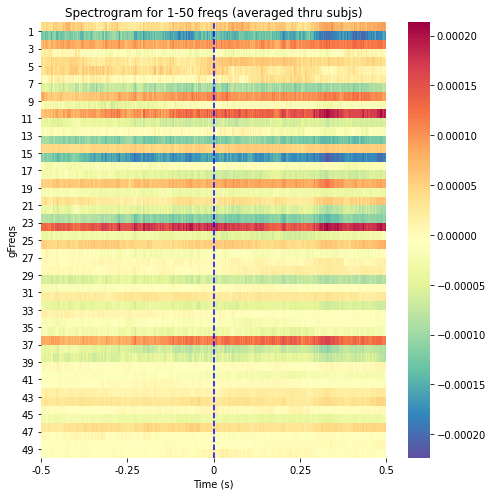

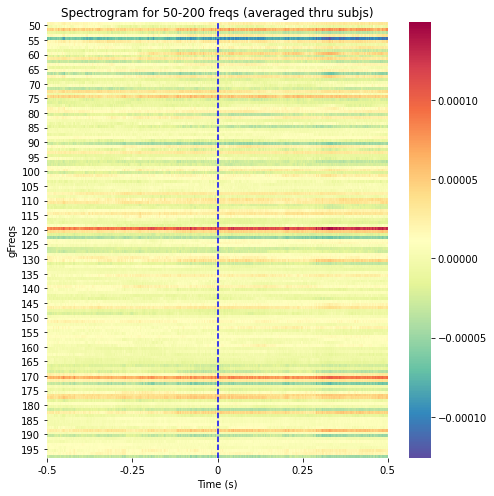

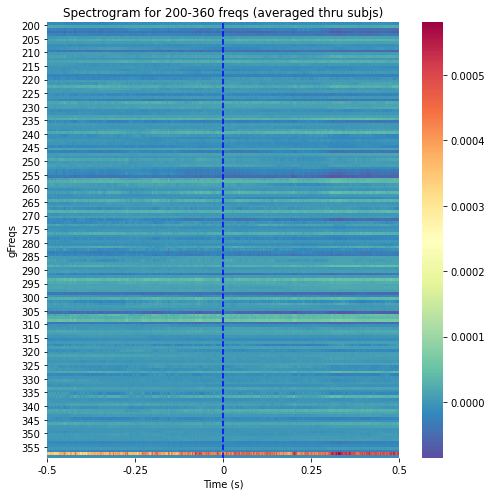

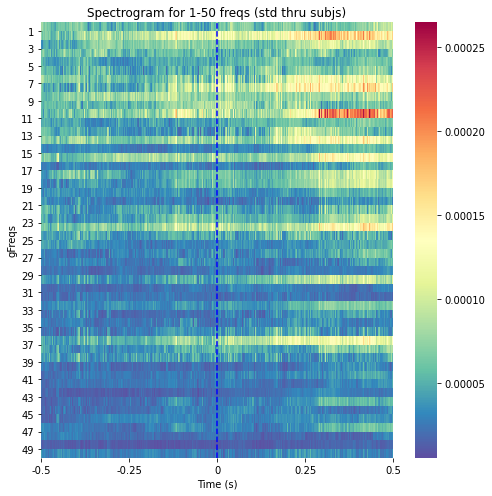

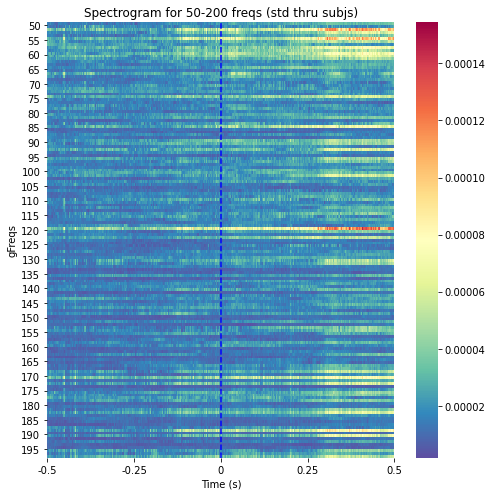

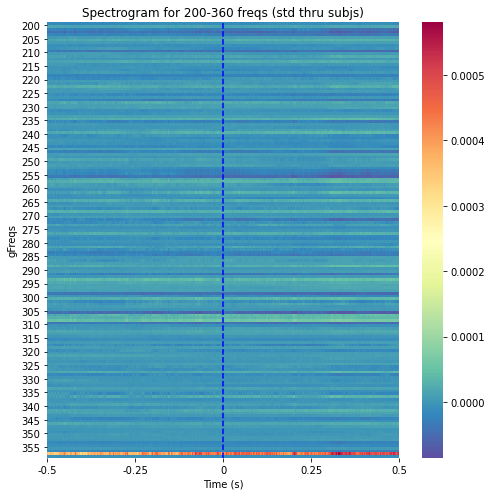

In [12]:

import matplotlib
import seaborn as sns
def heatmap(diff,title,start1,end1,div,start2,end2,operation,ylabel):
    plt.figure(figsize=(7,7))
    cmap_reversed = matplotlib.cm.get_cmap('Spectral').reversed()
    if operation == 'std':
        sns.heatmap(np.std(diff,axis=0),cmap=cmap_reversed) 
    else:
        sns.heatmap(np.average(diff,axis=0),cmap=cmap_reversed) 
    plt.ylabel(ylabel)
    plt.xlabel('Time (s)')
    plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
    plt.yticks(ticks=np.arange(start1,end1,div),labels=np.arange(start2,end2,div),rotation='horizontal')
    plt.axvline(x=250, linestyle = '--', color='b')
    #plt.axvline(x=132, linestyle = '--', color='b')
    plt.title(title)
    plt.tight_layout()
    plt.show()
heatmap(differenced_low_freq,'Spectrogram for 1-50 freqs (averaged thru subjs)',1,50,2,1,50,'AVG','gFreqs')# (differenced high with low & averaged through subjects )
heatmap(differenced_medium_freq,'Spectrogram for 50-200 freqs (averaged thru subjs)',1,150,5,50,200,'AVG','gFreqs')# (differenced high with low & averaged through subjects )
heatmap(differenced_high_freq,'Spectrogram for 200-360 freqs (averaged thru subjs)',1,160,5,200,360,'AVG','gFreqs')# (differenced high with low & averaged through subjects )


heatmap(differenced_low_freq,'Spectrogram for 1-50 freqs (std thru subjs)',1,50,2,1,50,'std','gFreqs')# (differenced high with low & averaged through subjects )
heatmap(differenced_medium_freq,'Spectrogram for 50-200 freqs (std thru subjs)',1,150,5,50,200,'std','gFreqs')# (differenced high with low & averaged through subjects )
heatmap(differenced_high_freq,'Spectrogram for 200-360 freqs (std thru subjs)',1,160,5,200,360,'AVG','gFreqs')# (differenced high with low & averaged through subjects )


### Subject-wise Spectra, while Time being variability

In [37]:
def mean_std(freq,ax):
    if ax>2:
        d = np.average(np.array(np.abs(freq)),axis=2)[:,1:]
    else: d = np.abs(freq[1:,:])
    mean_t = np.mean(d,axis=0)
    std_t = 2 * np.std(d,axis=0)
    top = mean_t + std_t
    bottom = mean_t - std_t
    
    return mean_t,std_t,top,bottom

### Power distribution finding

In [38]:
values,_,_,_ = mean_std(np.array(low_gft),3)
np.sum(values)/2

0.004102892687667312

In [39]:
np.sum(values[:142])

0.0041158380892656

In [42]:
G.e[143]

1.0240655747649001

### Dichotomy 

In [49]:
#1
l = np.where(G.e<=1.024)[0][1:]
h = np.where(G.e>1.024)[0]

In [65]:
def filters(isc,band,length):
    indicator = np.ones([1,length])
    cll =list() 
    cll.append(np.matmul(indicator,np.abs(np.array(isc)[0,band,:]))) # 1 x length & length x time
    for i in range(1,10):
        cll.append(np.matmul(indicator,np.abs(np.array(isc)[i,band,:])))
    cll = np.reshape(cll,[10,500])
    return cll

In [66]:


#def lowISC_high_ISC(*typ):
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(15,15))
typ = {'High ISC':high_gft,'Low ISC':low_gft}
for i in range(2):
        
        plt.subplot(a, b, c)
        cll1 = filters(typ[list(typ.keys())[i]],l,len(l))
        cll2 = filters(typ[list(typ.keys())[i]],h,len(h))
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)

        
        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='Low')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='High')
        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title(list(typ.keys())[i])
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
        
        #plt.ylabel('log (gPSD)')
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 1.02) such that the power distribution is same & sliced the PSD using the same [Low freq = blue] Note: used np.abs while using indicator')
plt.show()

# ideas:
#1. Sub-wise plot
#2. Freq-wise plot
#3. High - Low "dicotomized plot" and compare high - low heatmap



No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Frequency-wise


In [54]:


#def lowISC_high_ISC(*typ):
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(15,15))
typ = {'High ISC':high_gft,'Low ISC':low_gft}
freq = [l,h]
title = ['Low Frequency','High Frequency']
for i in range(2):
        
        plt.subplot(a, b, c)
        cll1 = filters(typ[list(typ.keys())[0]],freq[i],len(freq[i]))
        cll2 = filters(typ[list(typ.keys())[1]],freq[i],len(freq[i]))
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)

        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='High ISC')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='Low ISC')
        #plt.title('Graph PSD for the conditions (CI = Subjects. Time = 0.6 - 0.7s, 50 samples)')
        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title(title[i])
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
    
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 1.02) such that the power distribution is same & sliced the PSD using the same [blue = High ISC]')
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Subject-wise

In [89]:
%matplotlib qt
%gui qt


def filters_subj(isc,band,length):
    indicator = np.ones([1,length])
    cll =list() 
    cll.append(np.matmul(indicator,np.abs(np.array(isc)[band,:])))
    
    cll = np.reshape(cll,[1,500])
    d = np.abs(freq[1:,:])
    #mean_t = np.mean(d,axis=0)
    #std_t = 2 * np.std(d,axis=0)
    #top = mean_t + std_t
    #bottom = mean_t - std_t
    
    return cll

#def lowISC_high_ISC(*typ):
a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(10,10))
typ = {'High ISC':high,'Low ISC':low}
freq = [l,h]
for i in range(10):
        plt.subplot(a, b, c)
        cll1 = filters_subj(typ[list(typ.keys())[0]][i],freq[0],len(freq[0]))
        cll2 = filters_subj(typ[list(typ.keys())[0]][i],freq[1],len(freq[1]))
        
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)
        
        
        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='Low')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='High')
        #plt.title('Graph PSD for the conditions (CI = Subjects. Time = 0.6 - 0.7s, 50 samples)')
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
        

        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title('Low freq (high ISC = blue)')
        #plt.ylabel('log (gPSD)')
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 0.8) such that the power distribution is same & sliced the PSD using the same [Low freq = blue]')
plt.show()

/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/num

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/num

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/num

(1,)
(1,)
(1,)
(1,)


In [52]:
np.savez_compressed('data.npz',mean_t1=mean_t1, mean_t2=mean_t2,mean_std=mean_std )


high_isc = [(np.array(averaging_by_parcellation(src_high1))),(np.array(averaging_by_parcellation(src_high2))), 
       (np.array(averaging_by_parcellation(src_high3))), (np.array(averaging_by_parcellation(src_high4))), 
       (np.array(averaging_by_parcellation(src_high5))), (np.array(averaging_by_parcellation(src_high6))),
       (np.array(averaging_by_parcellation(src_high7))), (np.array(averaging_by_parcellation(src_high8))), 
       (np.array(averaging_by_parcellation(src_high9))), (np.array(averaging_by_parcellation(src_high10)))]

low_isc = [(np.array(averaging_by_parcellation(src_low1))),(np.array(averaging_by_parcellation(src_low2))), 
       (np.array(averaging_by_parcellation(src_low3))), (np.array(averaging_by_parcellation(src_low4))), 
       (np.array(averaging_by_parcellation(src_low5))), (np.array(averaging_by_parcellation(src_low6))),
       (np.array(averaging_by_parcellation(src_low7))), (np.array(averaging_by_parcellation(src_low8))), 
       (np.array(averaging_by_parcellation(src_low9))), (np.array(averaging_by_parcellation(src_low10)))]


diff = np.array(high_isc) - np.array(low_isc)




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
